In [1]:
import numpy as np
%load_ext autoreload
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter
from evaluator import Evaluator
from pauli_string import PauliString
from evaluator import BasicEvaluator
from qiskit import Aer, execute
from hamiltonian import MolecularFermionicHamiltonian
from Mapping import JordanWigner
from scipy.optimize import minimize
import os
os.environ['QISKIT_IN_PARALLEL'] = 'True' # this is to prevent broken_pool_process type error. We tell qiskit everything is already parallelized so it doenst have to do it itself.
from solver import VQESolver
from solver import ExactSolver
import matplotlib.pyplot as plt
from pyscf import gto

from qiskit.ignis.mitigation.measurement import complete_meas_cal
from qiskit.circuit import QuantumRegister
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram

In [2]:
from qiskit import IBMQ

#IBMQ.save_account('0df447ec9463e7ac6cf3d1690c64c05b8e133f1a834939ecdc98af2520539466ff8719fb63fbe9265e88a488ed8434d4d97657ae4dd7b81484cd0652f5e660dd',overwrite=True)
IBMQ.save_account('YOUR OWN API TO CONNECT TO IBM CLOUD')
IBMQ.load_account()
IBMQ.providers()

/Users/arthurperret/anaco3/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-education', group='qscitech-quantum', project='qc-bc-workshop')>]

We start by defining our minimizer that we will use throughout

In [3]:
minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5,'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 2})

We can then skip to the section of the notebook we want to run. Just beloew for the readout error mitigated.

Or next section for the zero noise level extrapolation. Each section should run independently from the other.

# 1.Readout error  mitigated ground energies of the H2 molecule

We now want to run the VQE algorithm on the IBM computer to have an estimate of the energie for different distance, with *mitigated readout noise*

We create our variationnal circuit, for a given parameter 'a'.

In [ ]:
varform_4qubits_1param = QuantumCircuit(4)
a = Parameter('a')
"""
Your code here

"""
varform_4qubits_1param.ry(a,1)
varform_4qubits_1param.x(0)
varform_4qubits_1param.cx(1,0)
varform_4qubits_1param.cx(0,2)
varform_4qubits_1param.cx(1,3)

varform_4qubits_1param.draw('mpl')

We now create the readout filter calibration  matrix.

First, we specifiy our backend.

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q-education')
provider.backends()
bogota = provider.get_backend('ibmq_bogota')

Here is the code for creating the calibration matrix (it runs on the actual quantum computer, it might take a while)

In [ ]:

qr = QuantumRegister(4)
qubit_list = [0,1,2,3]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

calibration_layout = [1,2,3,4]

result = execute(meas_calibs,
                 bogota,
                 shots=8192,
                 initial_layout=calibration_layout).result()

meas_fitter = CompleteMeasFitter(result, state_labels)
meas_filter = meas_fitter.filter

Next, we can run the actual variationnal algorithm to estimate the ground state energies.

First, we create our evaluator, to which we give the previous calibration matrix.

In [ ]:
varform = varform_4qubits_1param
backend = bogota
execute_opts = {'shots' : 8192}
evaluator = BasicEvaluator(varform,backend,execute_opts = execute_opts,zero_noise_extrapolation=0,measure_filter=meas_filter)

We can then run the code looping over some distance between the two H atoms. 

In first part of the loop, we create the molecule object for the desired distance. We extract from it the nuclear energy term that will be added at the end to the electronic term given by the quantum computer. We also create the molecular hamiltonian object.

Middle part is the mapping from a molecular basis, to the Jordan Wigner one.

Last part is the actual run on the quantum computer, where we give the pauli strings to the evaluator and a starting parameter for the variationnal algorithm. The output is the ground state energie, and the corresponding ground state.

# Careful, for 6 different distance value, this can take 1-2 hours

But it's not actually running on your computer, so it won't eat up all your memory while it's running

In [ ]:
distance = [0.25,0.5,0.73,1.0,1.5,2.0] #units in AA
ground_state_energies = []
for d in distance:
    mol = gto.M(
        atom = [['H', (0,0,-d/2)], ['H', (0,0,d/2)]], 
        basis = 'sto-3g'
        )
    energy_nuc = mol.energy_nuc()
    molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()
    
    mapping = JordanWigner()
    lcps_h2 = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).sort()
    lcps_h2 = lcps_h2.apply_threshold().combine().apply_threshold().sort()

    evaluator.set_linear_combinaison_pauli_string(lcps_h2)
    params = [0,]
    vqe_solver = VQESolver(evaluator,minimizer,[0,],name = 'vqe_solver')
    opt_value, opt_params = vqe_solver.lowest_eig_value(lcps_h2)
    ground_state_energies.append(opt_value+energy_nuc)

We can now print the corresponding energies.

In [ ]:
print(distance)
print('Ground state energies when readout noise is taken into account')
print(ground_state_energies)

We then save the value from the previous run in a vector for future reference. These values would of course be different between different runs.

In [ ]:
readout_mitigated_ground_energies = [-0.1530537421768745, -0.9219567670869995, -1.0400371588265842, -1.0108401166620284, -0.864354168014217, -0.8360694734588416]
result_readout_mitigated = dict(zip(distance,readout_mitigated_ground_energies))
print(result_readout_mitigated)

# 2. We now move to the zero noise extrapolation



The idea is to measure the energies for different noise level, and then extrapolate the value of the theoretical zero noise value. To measure at different noise level, we simply run (circuit * circuit_dag). By doing so, it amounts to doing the doing the circuit once, and then doing it in reverse. If there is no noise, this amounts to the identity and the energie values should not change. 

However, because there is noise, doing (circuit * circuit_dag) will do the (identity * any noise presents in the gates).

Hence doing U once will bring one time the amount of noise. (where U is the whole circuit operator).

Doing U * (U * U_dag) will bring 3 times the amount of noise.

Doing U * (U * U_dag) * (U * U_dag) will bring 5 times the amount of noise.


We again specify our backend



In [4]:
provider = IBMQ.get_provider(hub='ibm-q-education')
provider.backends()
bogota = provider.get_backend('ibmq_bogota') # to run on the bogota quantum computer
simulator = Aer.get_backend('qasm_simulator') # to run locally on a simulator
backend = bogota

Again, we create the circuit representing our variationnal form.

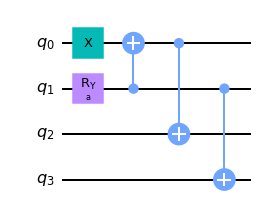

In [5]:
varform_4qubits_1param = QuantumCircuit(4)
a = Parameter('a')
"""
Your code here

"""
varform_4qubits_1param.ry(a,1)
varform_4qubits_1param.x(0)
varform_4qubits_1param.cx(1,0)
varform_4qubits_1param.cx(0,2)
varform_4qubits_1param.cx(1,3)

varform_4qubits_1param.draw('mpl')

Next, we will do a readout matrix calibration before every set of distance évaluation.

In other words, the pseudo code would look like this

For distance in distance_value:
    
    do matrix calibration
    
    for zero_noise_level in zero_noise_extrapolation:
    
        run solver and minimizer on quantum computer

We thus define what distance value we want to evaluate the ground energies

In [6]:
distance = [0.25,0.5,0.73,1.0,1.5,2.0] #units in AA
#We should split those value between us to speed up the process
noise_extrapolate_ground_state_energies = []

Next cell is then the whole procedure to run on the quantum computer

In [7]:
for d in distance:
    ### WE CREATE THE MOLECULE OBJECT AND MAP IT TO THE JORDAN-WIGNER REPRESENTATION
    mol = gto.M(
        atom = [['H', (0,0,-d/2)], ['H', (0,0,d/2)]], 
        basis = 'sto-3g'
        )
    energy_nuc = mol.energy_nuc()
    molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()
    
    mapping = JordanWigner()
    lcps_h2 = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).sort()
    lcps_h2 = lcps_h2.apply_threshold().combine().apply_threshold().sort()
    
    ### WE BUILD THE READOUT ERROR CALIBRATION MATRIX
    qr = QuantumRegister(4)
    qubit_list = [0,1,2,3]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    calibration_layout = [1,2,3,4]
    result = execute(meas_calibs,
                 backend,
                 shots=8192,
                 initial_layout=calibration_layout).result()

    meas_fitter = CompleteMeasFitter(result, state_labels)
    meas_filter = meas_fitter.filter
    
    ### WE THEN LOOP OVER THE ZERO NOISE LEVEL VALUE
    for zne_level in [0,1,2]:
        
        ### WE BUILD THE CORRESPONDING EVALUATOR OBJECT
        varform = varform_4qubits_1param
        backend = backend
        execute_opts = {'shots' : 8192}
        evaluator = BasicEvaluator(varform,backend,execute_opts = execute_opts,zero_noise_extrapolation=zne_level,measure_filter=meas_filter)

        evaluator.set_linear_combinaison_pauli_string(lcps_h2)
        params = [0,]
        vqe_solver = VQESolver(evaluator,minimizer,[0,],name = 'vqe_solver')
        opt_value, opt_params = vqe_solver.lowest_eig_value(lcps_h2)
        noise_extrapolate_ground_state_energies.append(opt_value+energy_nuc)

  NIT    FC           OBJFUN            GNORM
    1     3    -2.409226E+00     2.608557E-01
    2     6    -2.429404E+00     1.104403E-01
    3     9    -2.409393E+00     1.012727E-01
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.430032839647253
            Iterations: 3
            Function evaluations: 19
            Gradient evaluations: 3
  NIT    FC           OBJFUN            GNORM
    1     3    -2.409260E+00     2.413761E-01
    2     6    -2.430179E+00     9.753409E-02
    3     8    -2.427982E+00     4.606463E-02
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.4308724191596545
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
  NIT    FC           OBJFUN            GNORM
    1     3    -2.401081E+00     2.613362E-01
    2     6    -2.427484E+00     1.262672E-01
Optimization terminated successfully    (Exit mode 0)
            Current fun

In [8]:
print(noise_extrapolate_ground_state_energies)

[-0.3133239959672527, -0.31416357547965434, -0.3139057011244719, -1.0551801280345925, -1.0561738185236462, -1.0555413312066044, -1.1388874417250112, -1.1379824436987889, -1.1386283338123793, -1.0992779756069253, -1.100824233796911, -1.1026536998413685, -0.9997492333731, -0.9984048053540071, -1.0009043488594174, -0.9491755948733613, -0.9498461069626376, -0.9493040321381008]


In [9]:
print(distance)
print('ground state energies: row is for a given distance - column for a given noise level')
print(np.reshape(noise_extrapolate_ground_state_energies,(len(distance),3)))

[0.25, 0.5, 0.73, 1.0, 1.5, 2.0]
ground state energies: row is for a given distance - column for a given noise level
[[-0.313324   -0.31416358 -0.3139057 ]
 [-1.05518013 -1.05617382 -1.05554133]
 [-1.13888744 -1.13798244 -1.13862833]
 [-1.09927798 -1.10082423 -1.1026537 ]
 [-0.99974923 -0.99840481 -1.00090435]
 [-0.94917559 -0.94984611 -0.94930403]]


# 3. TO DO (MERGING ALL RESULTS TO DO NICE PLOTS)

- copy paste the exact eigensolver part of notebook 3-2 and run the diagonalization for all distance in order to get the exact dissociation curve


- get the value from an unmitigated noise run for a serie of distance
  *already done* 
  (  [0.08645276241096367, -0.7553925524784058, -0.87968911904096, -0.8946567902124557, -0.8020850281056371, -0.7097116503621499]  )
  

- get the value from a readout mitigated run for the same serie of distance (done, see the result from part 1 above)


- do the extrapolation from the noise extrapolated datapoints to get the estimated zero noise energie for the same serie of distance (TO BE DONE: IT WILL TAKE A LOT OF TIME, WE SHOULD SPLIT IT BETWEEN ALL OF US. EACH OF US RUN THE ALGORITHM FOR 2 DIFFERENT DISTANCE VALUE)


- plot all the thing together!